# Exercise 1 - Classification to predict student admission

## Imports

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm.notebook import trange

## Exercise steps

### a. Logistic regression classifier with linear decision boundary

#### a) Read the data from file

In a similar way as for the exercise of the previous week, read the training data from file `student-dataset-train.csv`. The first two columns are $x_{1}$ and $x_{2}$. The last column holds the class label $y$. Build the design matrix $X$ as follows:

<center>$X = \left(\begin{array}{ccc} 
        1 &   x_{1,1} & x_{1,2} \\
        1 &   \vdots  & \vdots  \\
        1 &   x_{N,1} & x_{N,2}
           \end{array}\right)$</center>

Check that the shape of $X$ is (100,3) and that the shape of $y$ is (100,).

In [3]:
df = pd.read_csv('student-dataset-train.csv', names = ['x1', 'x2', 'y'])
df.head()

,x1,x2,y
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [4]:
df.shape

(100, 3)

In [5]:
df['y'].shape

(100,)

In [6]:
X = df.iloc[:, :-1].values
# add the column of ones
X = np.hstack((np.ones((X.shape[0], 1)), X))
y = df.iloc[:, -1].values

#### b) Implement a z-norm normalization of the training set

You need to store the normalization values $(\mu, \sigma)$ for later as they will be needed to normalize the test set.

In [7]:
# z-normalize the data
mean = np.mean(X[:, 1:], axis = 0)
std = np.std(X[:, 1:], axis = 0)
X[:, 1:] = (X[:, 1:] - mean) / std

#### c) Implement a sigmoid function $g(z) = \frac{1}{1+e^{-z}}$

Use numpy to compute the exp so that your function can take numpy arrays as input. Check your implementation by plotting the sigmoid function.

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

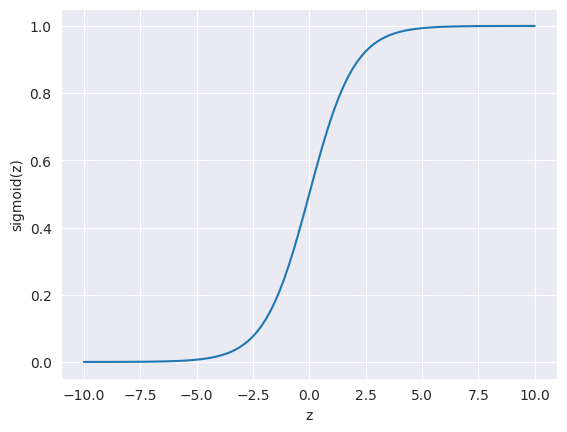

In [9]:
# plot the sigmoid function from -10 to 10
z = np.linspace(-10, 10, 100)
plt.plot(z, sigmoid(z))
plt.xlabel('z')
plt.ylabel('sigmoid(z)')
plt.show()

#### d) Implement the hypothesis function $h_{\theta}(\mathbf{x})$

Hint: implement it so that the computation can take the full array $X$ with $h(\mathbf{x})$ broadcasted to all training samples.

In [10]:
def hypothesis(X, theta):
   """
   X has a shape (N,D) and theta has a shape (D,)
   The doc product is then broadcast to a shape (N,) to all samples in x
   return array of shape (N,)
   """
   return sigmoid(X.dot(theta))

#### e) Implement the objective function $J(\theta)$

$J(\theta) = \frac{1}{N} \sum_{n=1}^{N} y_{n} \log h_{\theta}(\mathbf{x_{n}}) + (1-y_{n}) \log (1 - h_{\theta} (\mathbf{x_{n}}))$

In [11]:
# Your code here
def objective(X, y, theta):
   """
   Compute the cost function for all the training samples

   Params:
   X - input data
   y - labels
   theta - parameters

   Returns:
   J - cost
   """
   epsilon = 1e-6
   N = X.shape[0]
   h = hypothesis(X, theta)
   tmp = y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon)
   return np.sum(tmp) / N

#### f) Implement the gradient ascent

In a similar way as in PW02 and PW03, implement the gradient ascent with the update rule:

$\theta_{i} \leftarrow \theta_{i} + \alpha \frac{1}{N} \sum_{n=1}^{N} (y_{n} - h_{\theta}(\mathbf{x}_{n})) x_{n,i}$

In [86]:
def gradient_descent(X, y, theta, alpha, num_iters = 100):
   """
   Perform gradient descent to learn theta by taking num_iters steps
   with learning rate alpha

   Params:
   X - input data
   y - labels
   theta - parameters
   alpha - learning rate
   num_iters - number of iterations

   Returns:
   theta - learned parameters
   J_history - history of cost function
   """
   m = X.shape[0]
   J_history = []
   for _ in trange(num_iters):
       theta = theta - (alpha/m) * X.T @ (hypothesis(X, theta) - y)
       J_history.append(objective(X, y, theta))
   return theta, J_history

#### g) Test your implementation by running a gradient ascent

Hints: use a small $\alpha$. e.g. $0.001$,  store the evolution of the objective function $J(\theta)$ during the epochs to make a plot, use a large number of epochs, e.g. $2000000$.

In [45]:
theta, J_history = gradient_descent(X, y, np.zeros(X.shape[1]), 0.0001, 2000000)

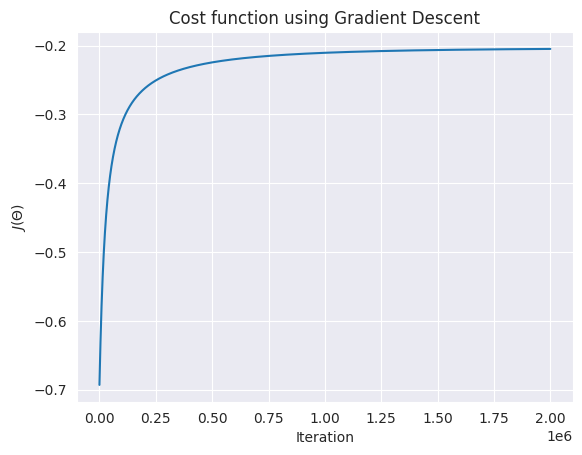

In [46]:
# plot the J_history vs iteration
plt.plot(J_history)
plt.xlabel('Iteration')
plt.ylabel('$J(\Theta)$')
plt.title('Cost function using Gradient Descent')
plt.show()

#### h) Compute the correct classification rate on `student-dataset-test.csv`

Compute the correct classification rate on `student-dataset-test.csv` after convergence as you have an estimator of the posterior probabilities with:

$P(y_{n}=1|\mathbf{x_{n}};\theta) = h_{\theta}(\mathbf{x_{n}})$
$P(y_{n}=0|\mathbf{x_{n}};\theta) = 1 - h_{\theta}(\mathbf{x_{n}})$

This means that you can take the decisions $\hat{y}_{n} = 1$ if $h_{\theta}(\mathbf{x_{n}}) \geq 0.5$ and $\hat{y}_{n} = 0$ if $h_{\theta}(\mathbf{x_{n}}) < 0.5$.

In [47]:
test = pd.read_csv('student-dataset-test.csv', names = ['x1', 'x2', 'y'])

In [48]:
X_test = test.iloc[:, :-1].values
# add the column of ones
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
y_test = test.iloc[:, -1].values

In [49]:
# normalize the test data
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

In [50]:
def predict(X, theta, threshold = 0.5):
   """
   Predict the label for the input data X

   Params:
   X - input data
   theta - parameters
   threshold - threshold for the sigmoid function

   Returns:
   y_pred - predicted labels 0 or 1
   """
   predicts = []
   for i in range(X.shape[0]):
       if hypothesis(X[i], theta) > threshold:
           predicts.append(1)
       else:
           predicts.append(0)
   return np.array(predicts)

In [51]:
predictions = predict(X_test, theta)

#### i) Draw the decision boundary

Draw the decision boundary of your system on top of the scatter plot of the testing data.

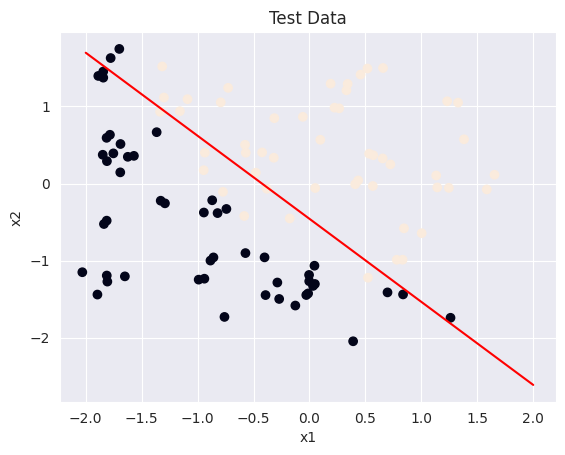

In [52]:
# scatter plot the test data
plt.scatter(X_test[:, 1], X_test[:, 2], c = y_test)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test Data')

# plot the decision boundary
x1 = np.linspace(-2, 2, 100)
x2 = -(theta[0] + theta[1] * x1) / theta[2]
plt.plot(x1, x2, c = 'r')
plt.show()

#### j) Compare the performance

Compare the performance of the logistic regression system with the ones of previous's week.

In [100]:
def show_perf(ax, name, y_true, y_pred):
    ax.set_title(f"{name} : {round(metrics.f1_score(y_true, y_pred)*100)/100}")
    ax.grid(False)
    cm = confusion_matrix(y_true,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)

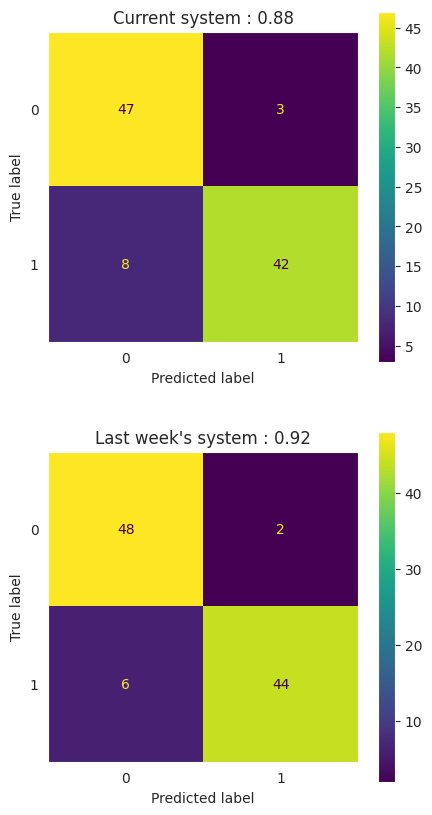

In [102]:
knn = KNeighborsClassifier(5)
knn.fit(X, y)
predictions_last_week = knn.predict(X_test)

_, ax = plt.subplots(2, 1, figsize=(5,10))

show_perf(ax[0], "Current system", y_test, predictions)
show_perf(ax[1], "Last week's system", y_test, predictions_last_week)

### b. Optional - Stochastic gradient ascent

Redo the experiments of 2.a with a stochastic gradient ascent.

In [105]:
# Your code here
# TODO OPT

### c. Logistic regression classifier with non-linear decision boundary

Redo the experiments of 2.a by increasing the complexity of the model in order to have a non-linear decision boundary:

<center>$h_{\theta}(\mathbf{x}) = g(\theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} + \theta_{3} x_{1}^{2} + \theta_{4} x_{2}^{2} + \theta_{5} x_{1}x_{2} + \ldots)$</center>

Gradient descent


  0%|          | 0/2000000 [00:00<?, ?it/s]

Plot history
Predicting


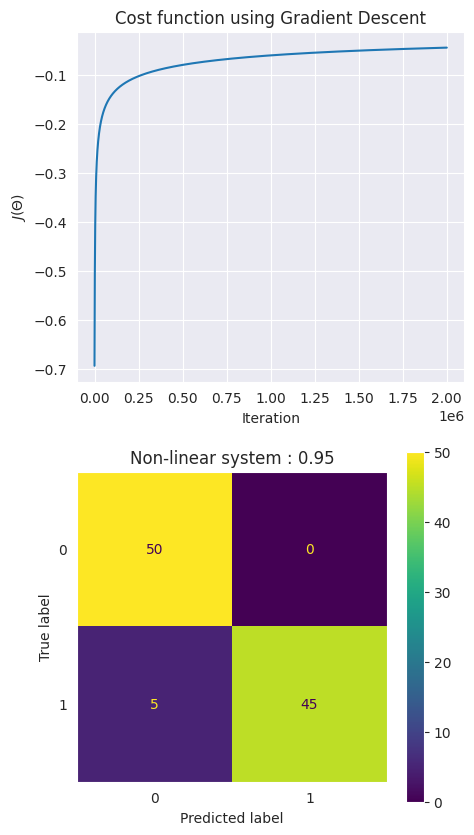

In [120]:
# Your code here
X_non_linear = np.c_[X, X[:,1]**2, X[:,2]**2, X[:,1]*X[:,2]]
X_test_non_linear = np.c_[X_test, X_test[:,1]**2, X_test[:,2]**2, X_test[:,1]*X_test[:,2]]

print("Gradient descent")
theta_non_linear, J_history = gradient_descent(X_non_linear, y, np.zeros(X_non_linear.shape[1]), 0.001, 2000000) 

_, ax = plt.subplots(2, 1, figsize=(5,10))

print("Plot history")
ax[0].plot(J_history)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('$J(\Theta)$')
ax[0].set_title('Cost function using Gradient Descent')

print("Predicting")
predictions_non_linear = predict(X_test_non_linear, theta_non_linear)

show_perf(ax[1], "Non-linear system", y_test, predictions_non_linear)

### d. Using SciKit Learn

Redo one of the exercise a. or c. using SciKit Learn.

1. Read the documentation of the function `SGDClassifier()` available in the toolkit SciKit Learn. This function implements stochastic gradient descent training for different linear systems such as Logistic Regression. For a logistic regression, the `loss` parameter should be set to `"log"`.
1. Use the `fit()` and `predict()` methods of this classifier on the student data.
1. Compute the performances and compare it to your own implementations.

In [114]:
# Your code here
model = SGDClassifier(max_iter=2000000, tol=0.001)
model.fit(X, y)

SGDClassifier(max_iter=2000000)

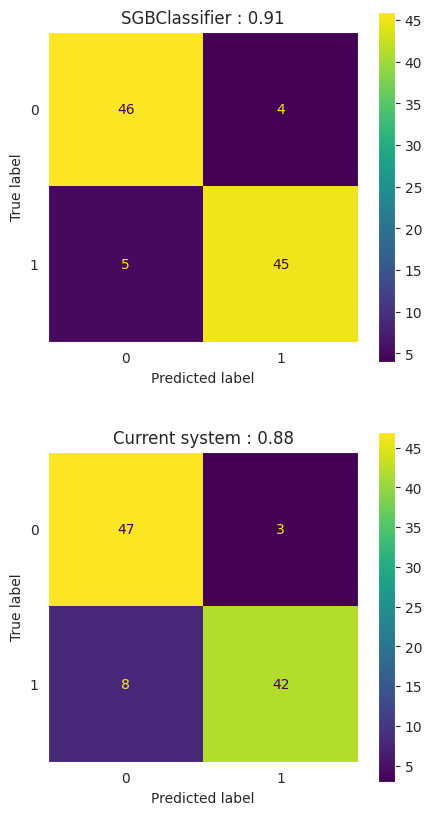

In [115]:
predictions_sgd = model.predict(X_test)

_, ax = plt.subplots(2, 1, figsize=(5,10))
show_perf(ax[0], "SGBClassifier", y_test, predictions_sgd)
show_perf(ax[1], "Current system", y_test, predictions)